# Plotting semantic differential data using 'likert' package

This notebook looks at how likert plots are generated with the *likert* R package and how they can be enhanced to display representations of semantic differential data.

# Purpose
The purpose of this notebook is to demonstrate how I worked with the *likert* package to produce plots of semantic differential type data and to propose integrating this into the base *likert* package.

## Likert-type scales

Likert type questions are frequently used in surveys or questionnaires along the lines of 'How much do you agree with this statement?', with answer options such as 'Disagree', 'Neither Agree nor Disagree', or 'Agree', or a numerical scale.

Below is a very poor approximation of what these questions might look like if someone didn't know how to style the form :)

In [30]:
library(IRdisplay)
html = '<h1>Notebook feedback questionnaire</h1>
<p>What do you think about this notebook? (1 = worst, 3 = best): 
<form action="">
  <input type="radio"> 1
  <input type="radio"> 2
  <input type="radio"> 3
</form></p>
<p>Are you satisfied with your experience today? 
<form action="">
  <input type="radio"> Not at all satisfied <br />
  <input type="radio"> It\'s OK <br />
  <input type="radio"> Great, couldn\'t be happier
</form></p>'
display_html(html)

Notebook feedback questionnaire 
 What do you think about this notebook? (1 = worst, 3 = best): 
 
 1
 2
 3
 
 Are you satisfied with your experience today? 
 
 Not at all satisfied 
 It's OK 
 Great, couldn't be happier

## Representing likert-type data
There are various ways that likert-type data can be represented, with one of the most common ways using divergent stacked bar charts.

## The 'likert' R package

The 'likert' package works over ggplot2 and does a great job of displaying this data using divergent stacked bar charts, density plots, and heat maps and provides various features for grouping the data. You should definitely consider using it if you are working with Likert-type data. There is some tricky tinkering under the hood to get the bar charts centered properly, definitely something you don't want to fiddle around with yourself.

It works very well for traditional plots and I want to see how I can make it work with semantic differential-type data.

## Semantic differentials

Semantic differentials are two concepts which are opposite in meaning (for example, 'good/bad' or 'comfortable/scared' and can be used with a likert-style scale with the respondant giving a level of association of one concept relative to the other.

These are quite common forms in questionnaire too and vary slightly in form from the previous examples in that instead of giving a response along a one dimensional axis (how much do you rate this from 1 to 5), there are two statements that you are interpolating and giving a point along that line.

The following section will go through the various methods to construct semantic differential graphs using different levels of hacking around the returned ggplot object and, finally, modifying the underlying 'likert' package itself to get the desired outcome.

The eventual aim of this is to make a proposal and mock up for representing this type of data in order to evaluate if it is worth making the effort to try and integrate this functionality back to the 'likert' package more natively.

# Creating semantic differential graphs

This uses the following example data hosted within this repository:
* **feedback_questionnaire_results.csv** - Contains example answers from 27 respondents to 6 questions on a scale of 1-5, where 1 is the most association with the left-based concept and 5 if the most association with the right-based concept.
* **sd-scales.csv** - Contains the left and right scales for each question. So for example using Q1, the left-based concept is *nervous* and the right-based concept is *confident*

In [31]:
# First load relevant packages
library(ggplot2)
library(likert)

In the **feedback_questionnaire_results.csv** file we have a 27 respondents for 6 questions, this is what will be used for the likert plot. Each answer is on a scale 1-5, where 1 is the maximum association with the left scale value and 5 is the maximum association with the right scale value.

In [34]:
feedback_responses.df <- read.csv('feedback_questionnaire_results.csv', na.strings = '', stringsAsFactors = FALSE)
head(feedback_responses.df)

person_id,Q1,Q2,Q3,Q4,Q5,Q6
1,5,5,3,4,1,2
2,3,2,4,2,3,4
3,5,3,4,4,4,3
4,5,1,5,5,1,2
5,4,3,3,4,2,3
6,2,2,3,4,2,3


In [6]:
summary(feedback_responses.df)

   person_id           Q1              Q2              Q3       
 Min.   : 1.00   Min.   :1.000   Min.   :1.000   Min.   :1.000  
 1st Qu.: 7.50   1st Qu.:3.000   1st Qu.:1.500   1st Qu.:4.000  
 Median :13.00   Median :4.000   Median :2.000   Median :4.000  
 Mean   :13.93   Mean   :3.593   Mean   :2.407   Mean   :3.926  
 3rd Qu.:20.50   3rd Qu.:4.000   3rd Qu.:3.000   3rd Qu.:4.500  
 Max.   :27.00   Max.   :5.000   Max.   :5.000   Max.   :5.000  
                                                                
       Q4              Q5              Q6       
 Min.   :1.000   Min.   :1.000   Min.   :1.000  
 1st Qu.:3.500   1st Qu.:1.000   1st Qu.:2.000  
 Median :4.000   Median :2.000   Median :3.000  
 Mean   :3.852   Mean   :1.846   Mean   :2.593  
 3rd Qu.:5.000   3rd Qu.:2.000   3rd Qu.:3.000  
 Max.   :5.000   Max.   :4.000   Max.   :5.000  
                 NA's   :1                      

**sd-scales.csv** provides the left and right labels for each item in the questionnaire. In this case a value of 1 for Q1 means that the respondent is nervous, whereas 5 means they are confident.

In [7]:
# The semantic differential labels for each question
sd_labels.df <- read.csv('sd-scales.csv', na.strings = '', stringsAsFactors = FALSE)
sd_labels.df

question,l_scale,r_scale
Q1,nervous,confident
Q2,stressed,relaxed
Q3,bored,interested
Q4,confused,clear
Q5,demotivated,motivated
Q6,overwhelmed,in control


## Initial likert plot

With this data we can the likert() function to turn the data frame into the data structure used by the specialised plot.likert function

In [35]:
# The respondent id is the first column in the df, which is not part of the likert plot
# There will be a warning about converting the response numbers into factors, this is fine.
feedback_responses.likert = likert(feedback_responses.df[,2:7], nlevels = 5)
feedback_responses.likert

Warning message in likert(feedback_responses.df[, 2:7], nlevels = 5):
“items parameter contains non-factors. Will convert to factors”

  Item         1         2        3         4         5
1   Q1  3.703704 11.111111 29.62963 33.333333 22.222222
2   Q2 25.925926 25.925926 37.03704  3.703704  7.407407
3   Q3  3.703704  3.703704 14.81481 51.851852 25.925926
4   Q4  3.703704 11.111111 11.11111 44.444444 29.629630
5   Q5 42.307692 34.615385 19.23077  3.846154  0.000000
6   Q6 22.222222 14.814815 48.14815 11.111111  3.703704

If we plot the data as is, each question will be labelled with just the question name, e.g. 'Q1'. Normally you would have more meaningful question titles along the left scale, but in this case, the question is in the title and we are going to replace the scale with the semantic labels.

Note that the likert package automatically re-orders the questions by level of 'positive' response, which helps to identify trends across the dataset.

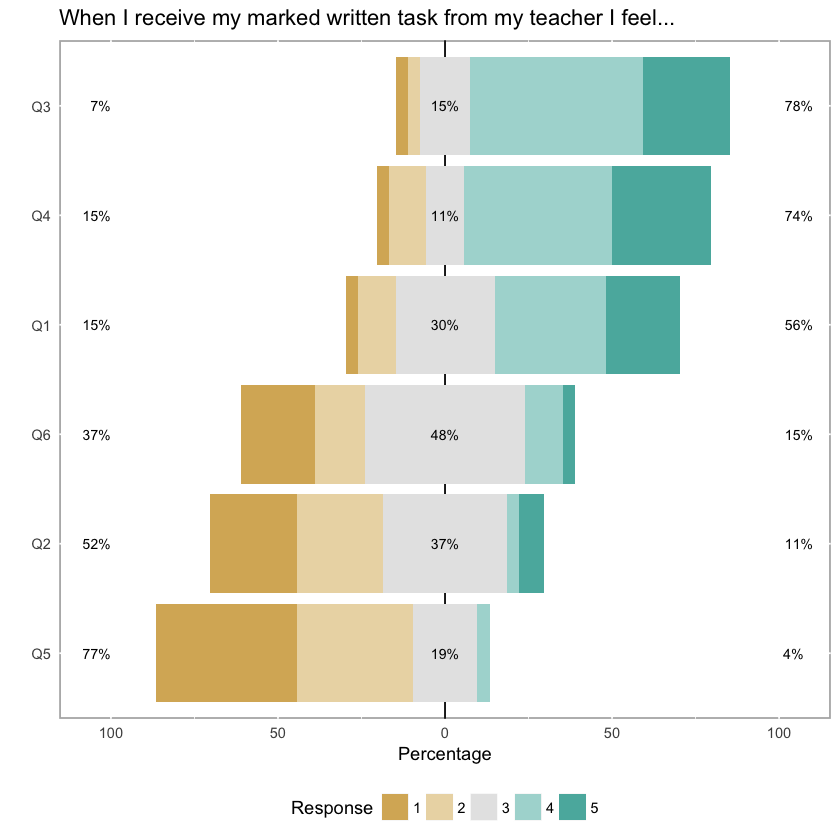

In [9]:
# This is the standard form of the likert plot
plot(feedback_responses.likert) +
  ggtitle(label = 'When I receive my marked written task from my teacher I feel...')

## Adding compound semantic labels
Now this plot is missing some key information - the semantic labels. How is anyone supposed to know how to intepret the plot without that?

One way to add the semantic labels is to concatenate them and replace the left-hand scale as such:

In [36]:
# Join the labels together and replace the question names e.g. 'nervous' + 'confident' = 'nervous/confident'
create_semantic_labels <- function(labels)
{
  return(paste(labels[2], labels[3], sep = "/"))
}
new_names <- apply(sd_labels.df, 1, create_semantic_labels)

# Create a new dataframe to keep things clean
feedback_responses_labelled.df  <- feedback_responses.df
colnames(feedback_responses_labelled.df)[2:7] <- new_names

# Generate a new likert data structure for plotting
feedback_responses_labelled.likert = likert(feedback_responses_labelled.df[,2:7], nlevels = 5)
feedback_responses_labelled.likert

Warning message in likert(feedback_responses_labelled.df[, 2:7], nlevels = 5):
“items parameter contains non-factors. Will convert to factors”

                    Item         1         2        3         4         5
1      nervous/confident  3.703704 11.111111 29.62963 33.333333 22.222222
2       stressed/relaxed 25.925926 25.925926 37.03704  3.703704  7.407407
3       bored/interested  3.703704  3.703704 14.81481 51.851852 25.925926
4         confused/clear  3.703704 11.111111 11.11111 44.444444 29.629630
5  demotivated/motivated 42.307692 34.615385 19.23077  3.846154  0.000000
6 overwhelmed/in control 22.222222 14.814815 48.14815 11.111111  3.703704

See how the question labels in the 'Item' column have changed, this will be reflected in the plot.

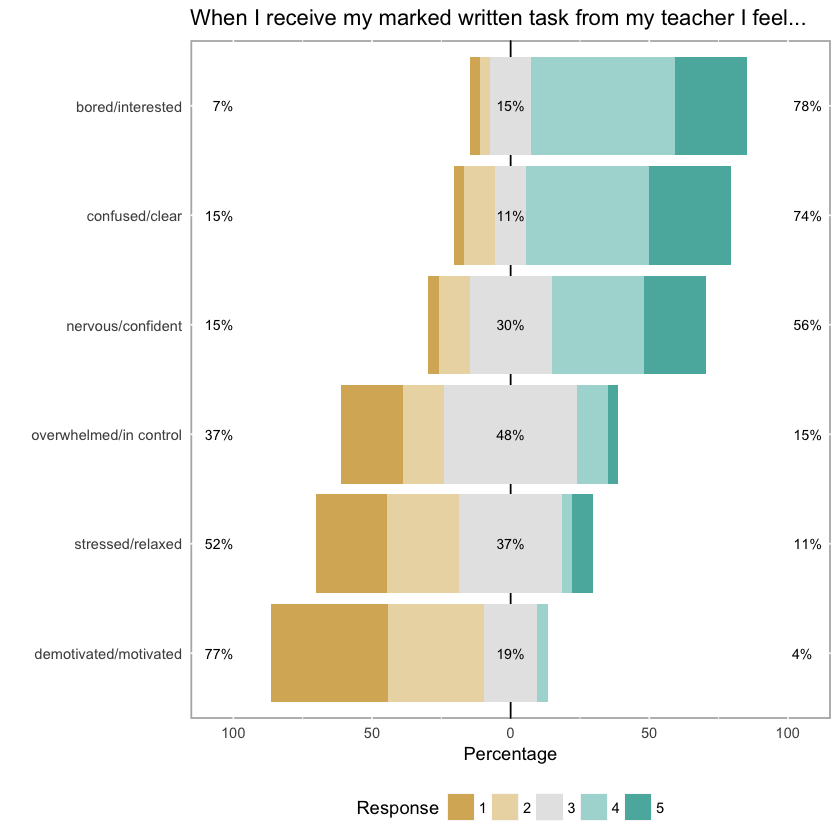

In [37]:
plot(feedback_responses_labelled.likert) +
  ggtitle(label = 'When I receive my marked written task from my teacher I feel...')

This is pretty good, but I think there would be a better information structure if the labels were either side of the main panel. So, instead of 'nervous/confident', have 'nervous' on the left-hand side of the panel and 'confident' on the right.

This is not supported by the likert package, and ultimately not well supported (intentionally so!) by the underlying ggplot package. The problem is that the current labelling is the y scale on the plot, so adding something equivalent on the right-hand side would be adding a second scale to the plot. There are various discussions about whether this is a good feature, but as it stands there is little support for it by the ggplot maintainers (this Stack Overflow question tells you most of what you need to know, including an authoritative answer from Hadley himself: http://stackoverflow.com/questions/3099219/plot-with-2-y-axes-one-y-axis-on-the-left-and-another-y-axis-on-the-right)

This means to get what I am looking for, there will need to be some hacking of the ggplot object to get the desired effect.

## Adding labels with *geom_text*

Working with two scales in ggplot is tricky, adding a scale to a plot which already has one will give a warning that the previous scale will be overridden. An approach around this is to discard the area outside of the plot main area entirely and work inside the plot panel where there is a more freedom to add extra text labels around data points.

The *plot.likert* function returns a ggplot object which we can add decorators to enhance and override elements in the plot. With *geom_text* elements we can add labels to the left and right of the bars to get the effect we are looking for. This means also that the scales need to be removed as their labels are now unnecessary.

As you can see below, this kind of achieves the effect but there are some clear problems:

1. The geom_text elements are clipped by the boundary of the panel. If the plot size is increased, then the text fits on as the font size does not increase with proportionately to the panel.
2. There is no scale, so when this plot is used inline with others the alignment of the title doesn't match up

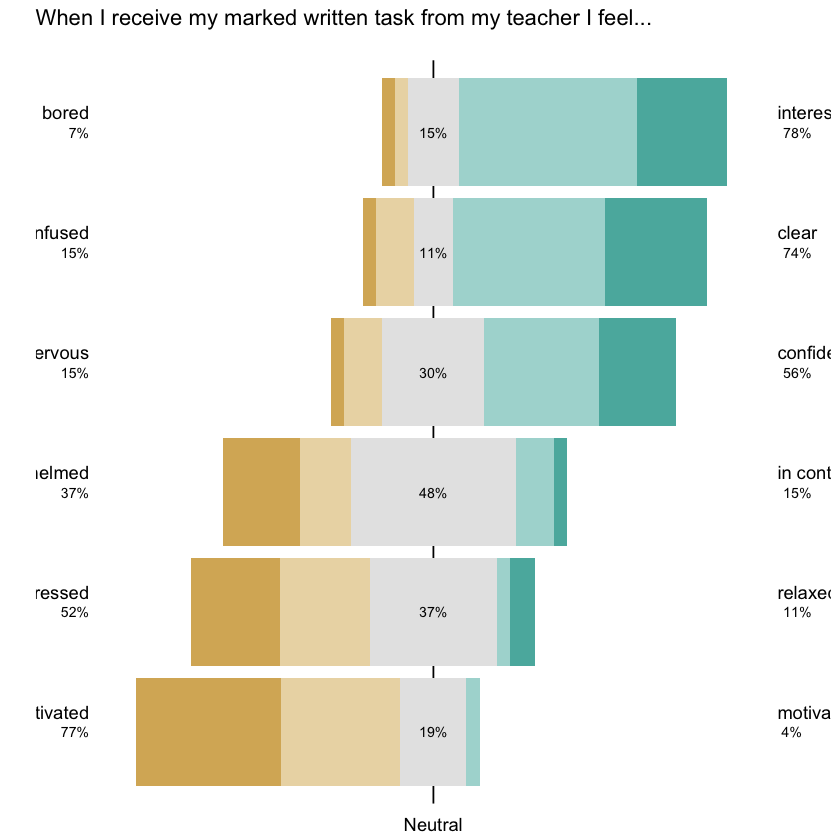

In [11]:
plot(feedback_responses.likert) +
  ggtitle(label = 'When I receive my marked written task from my teacher I feel...',
          subtitle = "") +
  geom_text(data=feedback_responses.likert$results, y=-100, aes(x=Item,
                                                                label=sd_labels.df$l_scale),
            vjust=-1, hjust=1) +
  geom_text(data=feedback_responses.likert$results, y=100, aes(x=Item,
                                                               label=sd_labels.df$r_scale),
            vjust=-1, hjust=0) +
  theme(panel.background = element_blank(),
        axis.text = element_blank(),
        legend.position = 'none') +
  ylab('Neutral')

## Using a dummy facet to mimic a right-hand scale

With the *geom_text* solution there are some clear drawbacks, and while the text clipping can be avoided if the plot is drawn large enough (the text size does not increase with the plot size), it does not fit cleanly enough into the aesthetic of the likert package for my tastes.

Another way to deal with this is to use *facet_grid* to create a facet with text on the right-hand side then update the facet style to match that of the left-hand scale. This is definitely abuse of the ggplot design but achieves the aims of having the semantic labelling of either side of the bars and conforming to the wider design aesthetic of the 'likert' package.

To make this work there are three steps involved:
1. The Item column is going to be the label on the left-hand side so this need to be relabelled with *sd_labels.df$l_scale*
2. For *facet_grid* we need to pass in a *labeller* which transforms the *l_scale* labels on the left step to the *r_scale* labels
3. Style the facet text so that it matches the style of the y-scale

In [41]:
# Create a new data frame
feedback_responses_faceted.df <- feedback_responses.df

# 1. Revalue the question naems to use the left-hand labels
colnames(feedback_responses_faceted.df)[2:7] <- sd_labels.df$l_scale
feedback_responses_faceted.likert = likert(feedback_responses_faceted.df[,2:7], nlevels = 5)
feedback_responses_faceted.likert

Warning message in likert(feedback_responses_faceted.df[, 2:7], nlevels = 5):
“items parameter contains non-factors. Will convert to factors”

         Item         1         2        3         4         5
1     nervous  3.703704 11.111111 29.62963 33.333333 22.222222
2    stressed 25.925926 25.925926 37.03704  3.703704  7.407407
3       bored  3.703704  3.703704 14.81481 51.851852 25.925926
4    confused  3.703704 11.111111 11.11111 44.444444 29.629630
5 demotivated 42.307692 34.615385 19.23077  3.846154  0.000000
6 overwhelmed 22.222222 14.814815 48.14815 11.111111  3.703704

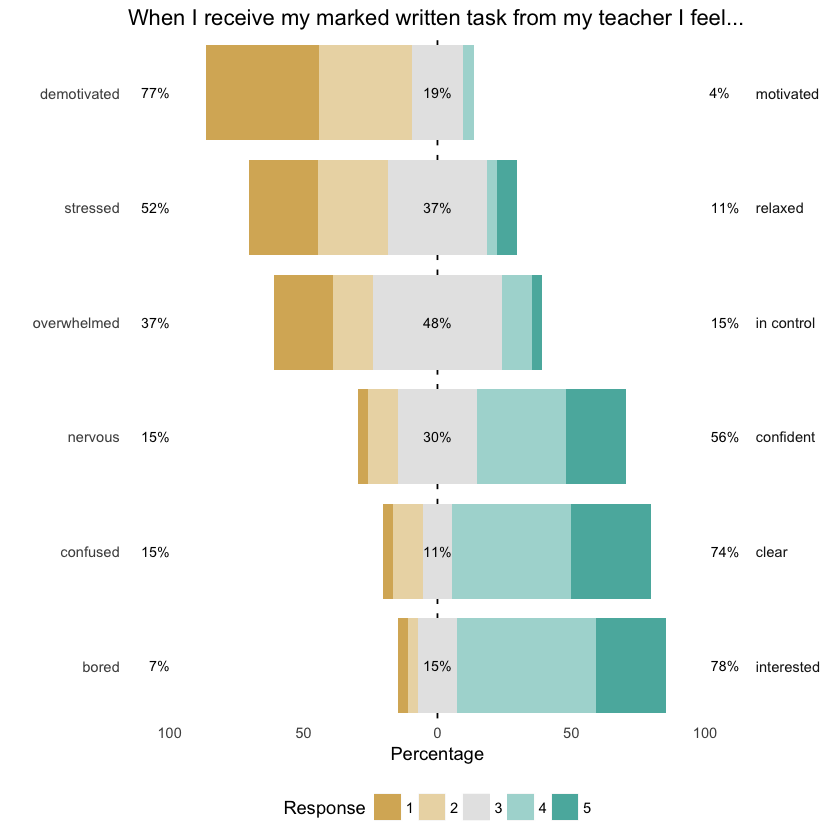

In [43]:
# 2. Create the labeller that will be used in the faceting
semantic_facet_labeller = setNames(sd_labels.df$r_scale, sd_labels.df$l_scale)

# 3. Plot using facet_grid
plot(feedback_responses_faceted.likert) +
  ggtitle(label = 'When I receive my marked written task from my teacher I feel...') +
  facet_grid(Item ~ ., scales = 'free_y', labeller = labeller(Item = semantic_facet_labeller)) +
  theme(strip.text.y = element_text(angle = 0, hjust = 0),
        strip.background = element_rect(fill = NA),
        panel.background = element_blank())

## Editing the *likert* package

This is pretty good approximation of what I am looking for ultimately. There are a few niggles, such as having to remove the background border (as the border would be around each facet), and the central black line for x=0 being broken up (as there are effectively 6 separate plot panels.

Additionally, the code above is not enough to be able to get the graph above, on it's own.  There is in fact a change required to the inside of the likert package to get this output above. In the scale generation inside the package, the unused factors in each scale need to be dropped otherwise each of the six labels appears next to each plot facet.

# Conclusion
This notebook goes through how to represent semantic differential-type data using divergent stacked bar charts produced by the 'likert' package. There is a bit of fiddling about, and ultimately to get a decent result some manipulation of the underlying package.

What I would like to do is build this in more natively to the package and submit a pull request for the changes. Going for full integration would definitely raise some more issues. There is a grouping feature of 'likert' which also uses faceting, and I am not clear how these two features can be made to interact well.

This is a proposal targetting the maintainers of the package and seeing if there is any interest on their side which would justify me working more on integrating this properly.

# Acknowledgements
Thanks to **jbryer** for creating the *likert* package in the first place. After spending some time looking through the source code, I can tell it was not a straightforward feat to get the divergent charts working so well!

Thanks also to the **London R Coding Dojo** for helping me work through some of the design ideas and suggesting implementation steps.